# 17대 젠더 관련 의안 분석

### 2004.05.30 ~ 2008.05.29 / 노무현, 이명박 정부

In [23]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [24]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [25]:
bill_df = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/17대 국회 의안정보.csv', 
                      parse_dates=['제안일자', '의결일자'], index_col=0)

bill_df = bill_df.drop_duplicates()
bill_df.shape

(7489, 9)

In [26]:
def preprocessing(text): 
    text = text.replace('■ 주요내용', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ').replace('■ 제안경위', ' ')
    text = text.replace('제안이유',' ').replace('주요내용',' ').replace('[',' ').replace(']',' ')
    text = text.replace('참고사항', ' ').replace('■ 위원회 수정이유', ' ').replace('■ 위원회 수정주요내용',' ')
    text = text.replace("'",' ').replace('□ 수정이유',' ').replace('주요골자', ' ').replace('■ 수정사항',' ')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return text.strip()

In [27]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(lambda x: hanja.translate(x, 'substitution'))
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 9.34 s, sys: 64.4 ms, total: 9.4 s
Wall time: 9.6 s
CPU times: user 70 ms, sys: 1.11 ms, total: 71.1 ms
Wall time: 71.6 ms
CPU times: user 4.77 ms, sys: 258 µs, total: 5.03 ms
Wall time: 5.08 ms


In [28]:
bill_df.head(1)

,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
의안번호,,,,,,,,,
178368,소해면상뇌증 예방에 관한 특별법안,2008-05-23,의원,2008-05-29,임기만료폐기,제17대 (2004~2008) 제273회,세계적으로 “소해면상뇌증”이라 불리는 “광우병”으로 인한 피해 및 우려가 확산...,농림해양수산위원회,"['유승희', '강기갑', '강혜숙', '김우남', '김재윤', '김춘진', '김태..."


## 젠더 관련 의안만 추리기

In [29]:
# 여성위원회와 여성가족위원회 함께! 
bill_df['소관위원회'].unique()

array(['농림해양수산위원회', '보건복지위원회', '건설교통위원회', '여성가족위원회', '법제사법위원회', '행정자치위원회',
       '문화관광위원회', '국회운영위원회', '교육위원회', '과학기술정보통신위원회', '환경노동위원회', '재정경제위원회',
       '국제경기대회지원특별위원회', '통일외교통상위원회', '방송통신특별위원회', '산업자원위원회', '정무위원회',
       '국방위원회', '정치관계법특별위원회', '정보위원회', nan, '2007-03-06', '2006-12-26',
       '2006-02-27', '2006-12-08', '2006-12-06', '2006-12-22',
       '2006-11-30', '2006-09-20', '2006-12-15', '2006-09-29',
       '2006-11-28', '2006-11-20', '2006-12-04', '2006-11-29',
       '2006-12-07', '2006-09-19', '2006-11-24', '2006-12-01',
       '2006-10-11', '2006-11-27', '미확정', '국회개혁특별위원회', '정치개혁특별위원회',
       '여성위원회'], dtype=object)

In [30]:
comm = bill_df[(bill_df['소관위원회'] == '여성위원회')|(bill_df['소관위원회'] == '여성가족위원회')]
comm['의안명'].unique()

array(['여성발전기본법 일부개정법률안', '성매매방지 및 피해자보호 등에 관한 법률 일부개정법률안',
       '영유아보육법 일부개정법률안', '다문화가족지원법안', '가족친화 사회환경의 조성 촉진에 관한 법률안',
       '모·부자복지법 일부개정법률안', '성매매 알선 적발업소 등의 규제에 관한 법률안',
       '가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안', '여성인력의 경제활동 진흥법안',
       '성폭력방지 및 피해자보호 등에 관한 법률안', '이주민가족의 보호 및 지원 등에 관한 법률안',
       '가족친화 사회환경 조성법안', '가족친화기업 촉진에 관한 법률안',
       '일제하 일본군위안부 피해자에 대한 생활안정지원 및 기념사업 등에 관한 법률 일부개정법률안',
       '혼혈인가족 지원에 관한 법률안', '건강가정기본법 일부개정법률안',
       '가정폭력방지및피해자보호등에관한법률 일부개정법률안', '평등가족기본법안', '건강가정기본법 전부개정법률안',
       '성매매방지및피해자보호등에관한법률 일부개정법률안', '가족지원기본법안',
       '일제하일본군위안부피해자에대한생활안정지원및기념사업등에관한법률 일부개정법률안', '남녀차별금지및구제에관한법률 폐지법률안',
       '영유아보육법중개정법률안'], dtype=object)

In [31]:
keyword = r'.*(여성|성범죄|남녀|호주|육아|보육|가부장|강간|간통죄|정조|성폭력|남녀평등|성차별|모성|성접대|낙태|부녀자|퇴폐|남여|미혼모|\
                성희롱|성보호|음란|가족|윤락|위안부|양성평등|양성 평등|스토킹|가정폭력|정신대|청소년|가정폭력|남녀차별|모자보건|출산|모부자\
                공중화장실|공중 화장실|공직선거법|공직 선거법|건강가족기본법|유산|사산|성인지|한부모|모·부자|건강가정|돌봄|성별|다문화|\
                가사노동|가사 노동|여교수|산전후휴가).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender.shape

(1220, 10)

In [32]:
gender[gender['의안번호'] == 174254]

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
602,174254,청소년보호법 일부개정법률안,2006-04-17,의원,2008-05-29,임기만료폐기,제17대 (2004~2008) 제259회,■ 농어업인과 농협에 대한 지방세 감면은 영농규모 확대 및 후계농업인의 육성 ...,정무위원회,"['지병문', '구논회', '김낙순', '김우남', '김재윤', '백원우', '양승..."


In [33]:
for ind in range(1000, len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '의안명'])
    print(gender.loc[ind, '제안이유'])

171652
남녀고용평등법 일부개정법률안
  ■  근로자가 배우자출산간호휴가 및 태아검진휴가를 경제적인 어려움을 받지 않고 자유롭게 사용할 수 있도록 하기 위하여는 유급휴가로 할 필요가 있음.그러나 배우자출산간호휴가 및 태아검진휴가에 대한 급여를 사업주가 부담하도록 할 경우에는 근로자가 휴가를 사용하는데 제약이 따를 수 있으므로 이를 국가 또는 사회보험으로 지급하도록 하려는 것임. 국가는 배우자출산간호휴가를 사용한 근로자 및 태아검진휴가를 사용한 여성근로자 중 일정한 요건에 해당하는 자에게 당해 휴가기간 에 해당하는 기간의 통상임금에 상당하는 금액을 지급하도록 함(안 제18조제1항).  
171651
고용보험법 일부개정법률안
  ■  근로자가 배우자출산간호휴가 및 태아검진휴가를 자유롭게 사용할 수 있도록 하기 위하여는 그 휴가에 따른 비용을 사업주가 아닌 고용보험에서 부담하게 할 필요가 있음.이에 배우자출산간호휴가급여 및 태아검진휴가급여를 고용보험에서 지급하도록 하려는 것임. 노동부장관은 피보험자가 배우자출산휴가 및 태아검진휴가를 부여받은 경우에는 그 휴가기간에 대하여 배우자출산간호휴가급여 및 태아검진휴가급여를 지급하도록 함(안 제55조의7 및 제55조의8).  
171650
근로기준법 일부개정법률안
  ■  임신중인 여성은 자신과 태아를 위하여 정기적인 건강검진을 받을 필요가 있고, 이를 원활히 받기 위하여는 임신중 휴가의 사용이 불가피함. 그러나 임신중인 여성 노동자들이 태아와 자신의 건강검진을 위하여 적절히 사용할 수 있는 별도의 휴가규정이 없는 실정임.또한 핵가족화가 일반화되면서 여성의 출산시 간호할 수 있는 가족이 배우자 외에 현실적으로 존재하지 않는 경우가 많아 실제로 여성과 신생아를 간호할 수 있는 배우자의 출산간호휴가가 절실히 필요한 실정임.이에 임신중 태아검진휴가 부여를 명문화하며, 배우자에게도 출산간호휴가를 주도록 하려는 것임. 가. 사용자는 출산여성의 배우자인 근로자에게 7일의 배우자출산간호휴가를 주도록 함(안 제71조의2 신설).나. 사용

In [34]:
remove_bill = [178367, 178366, 178365, 178353, 178348, 178323, 178296, 178288, 178280, 178270, 178269, 178247, 
               178225, 178220, 178206, 178172, 178126, 178097, 178074, 178051, 178045, 178041, 177999, 177991, 
               177988, 177984, 177980, 177979, 177974, 177945, 177929, 177924, 177890, 177884, 177880, 177870, 
               177861, 177852, 177834, 177831, 177829, 177823, 177797, 177794, 177791, 177774, 177765, 177717, 
               177705, 177703, 177700, 177696, 177690, 177682, 177673, 177670, 177668, 177660, 177657, 177642, 
               177627, 177621, 177586, 177532, 177518, 177510, 177506, 177504, 177501, 177489, 177472, 177434, 
               177428, 177424, 177408, 177406, 177389, 177387, 177369, 177355, 177350, 177322, 177317, 177316, 
               177315, 177291, 177244, 177223, 177217, 177200, 177187, 177186, 177166, 177165, 177162, 177156, 
               177112, 177109, 177107, 177094, 177088, 177087, 177086, 177063, 177037, 177033, 177021, 177014, 
               177009, 176993, 176984, 176982, 176981, 176978, 176977, 176974, 176964, 176924, 176946, 176935, 
               176906, 176901, 176896, 176886, 176879, 176878, 176871, 176847, 176801, 176793, 176784, 176777, 
               176776, 176735, 176689, 176688, 176687, 176686, 176685, 176684, 176683, 176682, 176670, 176666, 
               176661, 176657, 176656, 176633, 176631, 176615, 176601, 176593, 176566, 176558, 176553, 176530, 
               176529, 176523, 176508, 176436, 176433, 176429, 176426, 176425, 176421, 176418, 176412, 176390, 
               176383, 176373, 176362, 176359, 176342, 176340, 176340, 176339, 176323, 176322, 176314, 176298, 
               176278, 176276, 176251, 176229, 176209, 176183, 176169, 176168, 176158, 176157, 176155, 176151, 
               176134, 176133, 176132, 176123, 176121, 176112, 176087, 176086, 176084, 176082, 176077, 176076, 
               176141, 176051, 176047, 176046, 176032, 176024, 176023, 176022, 176017, 176000, 175987, 175985, 
               175972, 175971, 175968, 175966, 175956, 175947, 175942, 175938, 175935, 175925, 175910, 175891, 
               175847, 175838, 175835, 175804, 175803, 175790, 175782, 175780, 175770, 175734, 175719, 175694,
               175686, 175678, 175677, 175665, 175648, 175640, 175628, 175619, 175618, 175617, 175604, 175576, 
               175563, 175561, 175559, 175558, 175556, 175538, 175537, 175528, 175527, 175518, 175516, 175514,
               175489, 175485, 175450, 175404, 175378, 175374, 175366, 175352, 175350, 175338, 175328, 175326, 
                175313, 175312, 175309, 175291, 175286, 175280, 175247, 175240, 175236, 175228, 175217, 175216, 
                175184, 175175, 175173, 175169, 175165, 175161, 175159, 175104, 175087, 175083, 175047, 175045, 
                175027, 175001, 174993, 174979, 174978, 174952, 174913, 174894, 174887, 174882, 174881, 174878, 
                174866, 174846, 174820, 174813, 174810, 174798, 174797, 174782, 174776, 174774, 174771, 174770, 
                174749, 174734, 174728, 174727, 174725, 174722, 174709, 174702, 174682, 174681, 174678, 174669, 
                174649, 174642, 174638, 174630, 174626, 174624, 174599, 174576, 174573, 174556, 174537, 
                174525, 174512, 174504, 174487, 174485, 174479, 174470, 174437, 174431, 174428, 174418, 174413, 
                174410, 174407, 174400, 174395, 174393, 174392, 174388, 174359, 174355, 174344, 174331, 174316, 
                174304, 174283, 174272, 174271, 174255, 174254, 174245, 174244, 174241, 174236, 174226, 174218, 
                174208, 174207, 174203, 174202, 174198, 174196, 174189, 174167, 174165, 174151, 174124, 174119, 
                174119, 174118, 174116, 174115, 174109, 174101, 174088, 174079, 174066, 174059, 174046, 174042, 
                174029, 174024, 174015, 174013, 174009, 173998, 173986, 173977, 173976, 173974, 173969, 173966, 
                173955, 173951, 173946, 173943, 173936, 173931, 173917, 173907, 173899, 173896, 173895, 173882, 
                173872, 173870, 173867, 173866, 173849, 173803, 173793, 173744, 173742, 173736, 173710, 173676, 
                173655, 173653, 173624, 173612, 173609, 173589, 173572, 173562, 173558, 173555, 173545, 173540, 
                173534, 173523, 173521, 173518, 173507, 173504, 173502, 173499, 173496, 173484, 173483, 173474, 
                173473, 173460, 173434, 173423, 173417, 173415, 173408, 173406, 173365, 173362, 173353, 173347, 
                173332, 173294, 173290, 173271, 173269, 173264, 173262, 173258, 173253, 173238, 173220, 173199, 
                173197, 173187, 173185, 173183, 173162, 173160, 173154, 173151, 173149, 173147, 173146, 173135, 
                173130, 173129, 173118, 173114, 173052, 173000, 172997, 172996, 172991, 172990, 172984, 172968, 
                172967, 172953, 172947, 172946, 172929, 172920, 172918, 172914, 172910, 172907, 172890, 172882, 
                172881, 172875, 172865, 172864, 172847, 172842, 172831, 172824, 172708, 172700, 172690, 172672,
               172669, 172628, 172613, 172587, 172586, 172584, 172582, 172580, 172571, 172565, 172550, 172511, 
                172510, 172478, 172471, 172466, 172456, 172452, 172432, 172429, 172428, 172426, 172405, 172404, 
                172403, 172402, 172399, 172394, 172391, 172386, 172382, 172378, 172377, 172374, 172370, 172369, 
                172363, 172362, 172359, 172356, 172351, 172321, 172319, 172311, 172308, 172304, 172296, 172290, 
                172287, 172285, 172275, 172273, 172271, 172270, 172269, 172268, 172267, 172263, 172262, 172255, 
                172248, 172247, 172246, 172245, 172233, 172218, 172217, 172195, 172174, 172169, 172168, 172135, 
                172134, 172123, 172116, 172115, 172111, 172109, 172101, 172083, 172077, 172063, 172060, 172049, 
                172032, 172001, 171995, 171983, 171967, 171946, 171925, 171918, 171915, 171908, 171907, 171906, 
                171898, 171893, 171845, 171835, 171831, 171823, 171809, 171807, 171803, 171787, 171763, 171762, 
                171752, 171733, 171707, 171702, 171691, 171669, 171662, 171661, 171658, 171632, 171627, 171625, 
                171615, 171614, 171595, 171586, 171568, 171562, 171548, 171546, 171541, 171530, 171505, 171501, 
                171492, 171476, 171454, 171402, 171390, 171373, 171372, 171368, 171355, 171349, 171346, 171338, 
                171328, 171311, 171284, 171264, 171260, 171259, 171258, 171235, 171227, 171224, 171220, 171201, 
                171189, 171180, 171177, 171172, 171128, 171110, 171101, 171099, 171098, 171084, 171079, 171074, 
                171073, 171018, 171005, 171001, 170988, 170983, 170978, 170941, 170932, 170930, 170910, 170906, 
                170881, 170849, 170848, 170827, 170826, 170819, 170803, 170797, 170784, 170773, 170772, 170766, 
                170753, 170729, 170721, 170710, 170709, 170694, 170693, 170676, 170674, 170669, 170650, 170649, 
                170646, 170641, 170633, 170617, 170616, 170611, 170609, 170605, 170581, 170575, 170568, 170561, 
                170557, 170548, 170532, 170528, 170505, 170485, 170482, 170475, 170460, 170449, 170430, 170421, 
                170420, 170381, 170374, 170363, 170333, 170331, 170322, 170306, 170302, 170296, 170294, 170291, 
                170290, 170286, 170269, 170264, 170260, 170200, 170199, 170194, 170151, 170138, 170113, 170111, 
                170090, 170088, 170065, 170040, 170021, 170011, 170010]
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(424, 10)

In [35]:
gender.to_csv('17th-gender-bill.csv',encoding='utf-8-sig')

## wordcloud 시각화

In [14]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [15]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [16]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 54.8 ms, sys: 1.84 ms, total: 56.6 ms
Wall time: 62.1 ms


In [17]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [18]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 45.7 s, sys: 635 ms, total: 46.3 s
Wall time: 28.3 s


0    [여성발전기본법, 일부개정법률안, 김기현의원, 대표발의, 여성발전기본법, 일부개정법...
1    [성매매방지, 피해자보호, 법률, 일부개정법률안, 회국회, 임시회, 여성위원회, 유...
2    [성폭력범죄, 처벌, 피해자보호, 법률, 일부개정법률안, 정부, 발의, 발의, 성폭...
Name: tokens, dtype: object

In [19]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 140 ms, sys: 2.91 ms, total: 143 ms
Wall time: 148 ms


In [20]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [21]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-16 11:54:15,662 : INFO : collecting all words and their counts
2020-09-16 11:54:15,669 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-16 11:54:15,690 : INFO : collected 8587 word types from a corpus of 56826 raw words and 423 sentences
2020-09-16 11:54:15,691 : INFO : Loading a fresh vocabulary
2020-09-16 11:54:15,706 : INFO : effective_min_count=10 retains 1095 unique words (12% of original 8587, drops 7492)
2020-09-16 11:54:15,707 : INFO : effective_min_count=10 leaves 39516 word corpus (69% of original 56826, drops 17310)
2020-09-16 11:54:15,716 : INFO : deleting the raw counts dictionary of 8587 items
2020-09-16 11:54:15,718 : INFO : sample=0.001 downsamples 66 most-common words
2020-09-16 11:54:15,719 : INFO : downsampling leaves estimated 34703 word corpus (87.8% of prior 39516)
2020-09-16 11:54:15,723 : INFO : estimated required memory for 1095 words and 100 dimensions: 1423500 bytes
2020-09-16 11:54:15,725 : INFO : resetting layer wei

2020-09-16 11:54:16,621 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:16,625 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:16,627 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:16,628 : INFO : EPOCH - 15 : training on 56826 raw words (34668 effective words) took 0.0s, 1100529 effective words/s
2020-09-16 11:54:16,660 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:16,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:16,666 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:16,669 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:16,670 : INFO : EPOCH - 16 : training on 56826 raw words (34719 effective words) took 0.0s, 970455 effective words/s
2020-09-16 11:54:16,703 : INFO : worker thread finished; awaiting finish of 3 more threads
202

2020-09-16 11:54:17,284 : INFO : EPOCH - 31 : training on 56826 raw words (34664 effective words) took 0.0s, 895565 effective words/s
2020-09-16 11:54:17,320 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:17,322 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:17,325 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:17,327 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:17,329 : INFO : EPOCH - 32 : training on 56826 raw words (34736 effective words) took 0.0s, 928398 effective words/s
2020-09-16 11:54:17,357 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:17,361 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:17,365 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:17,366 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-09-16 11:54:17,960 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:17,963 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:17,964 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:17,966 : INFO : EPOCH - 48 : training on 56826 raw words (34719 effective words) took 0.0s, 1004753 effective words/s
2020-09-16 11:54:17,995 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:18,002 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:18,003 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:18,005 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:18,007 : INFO : EPOCH - 49 : training on 56826 raw words (34671 effective words) took 0.0s, 1026605 effective words/s
2020-09-16 11:54:18,041 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-16 11:54:18,596 : INFO : EPOCH - 64 : training on 56826 raw words (34734 effective words) took 0.0s, 955138 effective words/s
2020-09-16 11:54:18,626 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:18,627 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:18,631 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:18,633 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:18,634 : INFO : EPOCH - 65 : training on 56826 raw words (34688 effective words) took 0.0s, 1112689 effective words/s
2020-09-16 11:54:18,663 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:18,665 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:18,668 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:18,669 : INFO : worker thread finished; awaiting finish of 0 more threads
202

2020-09-16 11:54:19,239 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:19,245 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:19,246 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:19,249 : INFO : EPOCH - 81 : training on 56826 raw words (34795 effective words) took 0.0s, 804211 effective words/s
2020-09-16 11:54:19,282 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:19,284 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:19,287 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:19,288 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:19,289 : INFO : EPOCH - 82 : training on 56826 raw words (34778 effective words) took 0.0s, 1001616 effective words/s
2020-09-16 11:54:19,316 : INFO : worker thread finished; awaiting finish of 3 more threads
202

2020-09-16 11:54:19,900 : INFO : EPOCH - 97 : training on 56826 raw words (34750 effective words) took 0.0s, 924901 effective words/s
2020-09-16 11:54:19,938 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:19,938 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:19,940 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:19,940 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-16 11:54:19,942 : INFO : EPOCH - 98 : training on 56826 raw words (34654 effective words) took 0.0s, 902416 effective words/s
2020-09-16 11:54:19,977 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-16 11:54:19,979 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-16 11:54:19,981 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-16 11:54:19,985 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

In [28]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

[('사회참여', 0.5048307180404663), ('보장하', 0.43558046221733093), ('남성', 0.43084239959716797), ('여성근로자', 0.40227434039115906), ('휴가', 0.3843322992324829), ('실정', 0.3784427344799042), ('모성보호', 0.37331265211105347), ('수준', 0.36551666259765625), ('직업능력개발훈련', 0.3602280020713806), ('근로자', 0.35622143745422363)]
[('신상정보', 0.5068498253822327), ('성범죄자', 0.4816785454750061), ('강제추행', 0.4635704457759857), ('성범죄', 0.426089882850647), ('범죄', 0.41890645027160645), ('국가청소년위원회', 0.4187904894351959), ('노출', 0.41496747732162476), ('청소년들', 0.40084701776504517), ('강간', 0.39866799116134644), ('위험성', 0.39329230785369873)]


In [23]:
gender['tokens']

0      [여성발전기본법, 일부개정법률안, 김기현의원, 대표발의, 여성발전기본법, 일부개정법...
1      [성매매방지, 피해자보호, 법률, 일부개정법률안, 회국회, 임시회, 여성위원회, 유...
2      [성폭력범죄, 처벌, 피해자보호, 법률, 일부개정법률안, 정부, 발의, 발의, 성폭...
3      [성폭력범죄, 처벌, 피해자보호, 법률, 일부개정법률안, 미성년자, 대상, 성폭행,...
4      [성폭력범죄, 처벌, 피해자보호, 법률, 일부개정법률안, 미성년자, 대상, 성폭행,...
                             ...                        
418    [교육공무원법중개정법률, 입양, 부정적, 변화, 국내입양, 활성화하기, 자녀, 입양...
419    [사립학교법중개정법률, 입양, 부정적, 변화, 국내입양, 활성화하기, 자녀, 입양,...
420    [지방공무원법중개정법률, 입양, 부정적, 변화, 국내입양, 활성화하기, 자녀, 입양...
421    [국가공무원법중개정법률, 입양, 부정적, 변화, 국내입양, 활성화하기, 자녀, 입양...
422    [민법중개정법률, 호주, 중심, 구성, 호주제도, 헌법, 보장하, 남녀평등, 개인,...
Name: tokens, Length: 423, dtype: object

In [24]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [25]:
gender_word = total_tokens(gender['tokens'])

In [26]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','규정함','본회','수립','항제', '의결제','촉진','의결',
            '영역','도모','확대','구현','이외','원안폐','조등']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

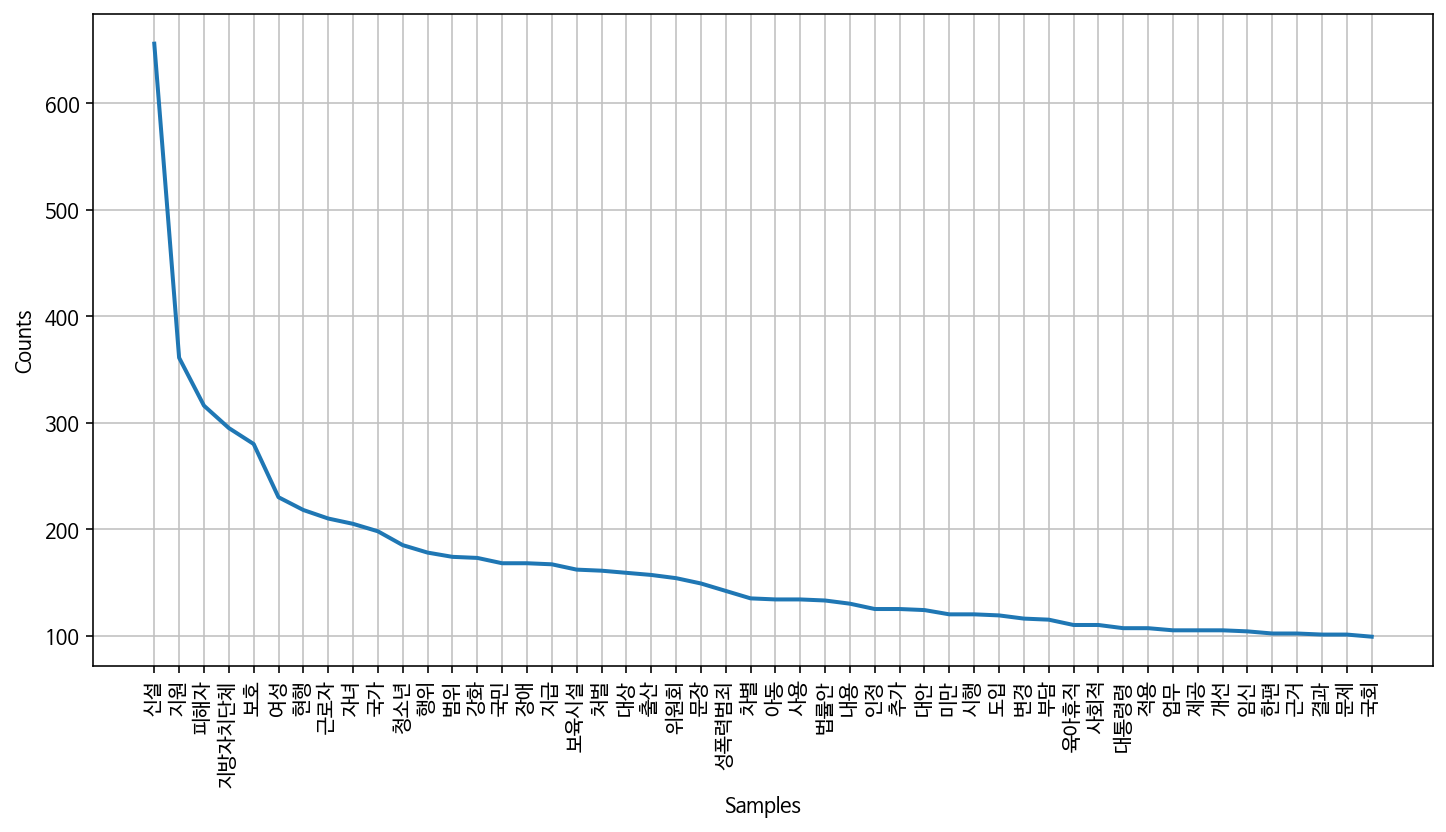

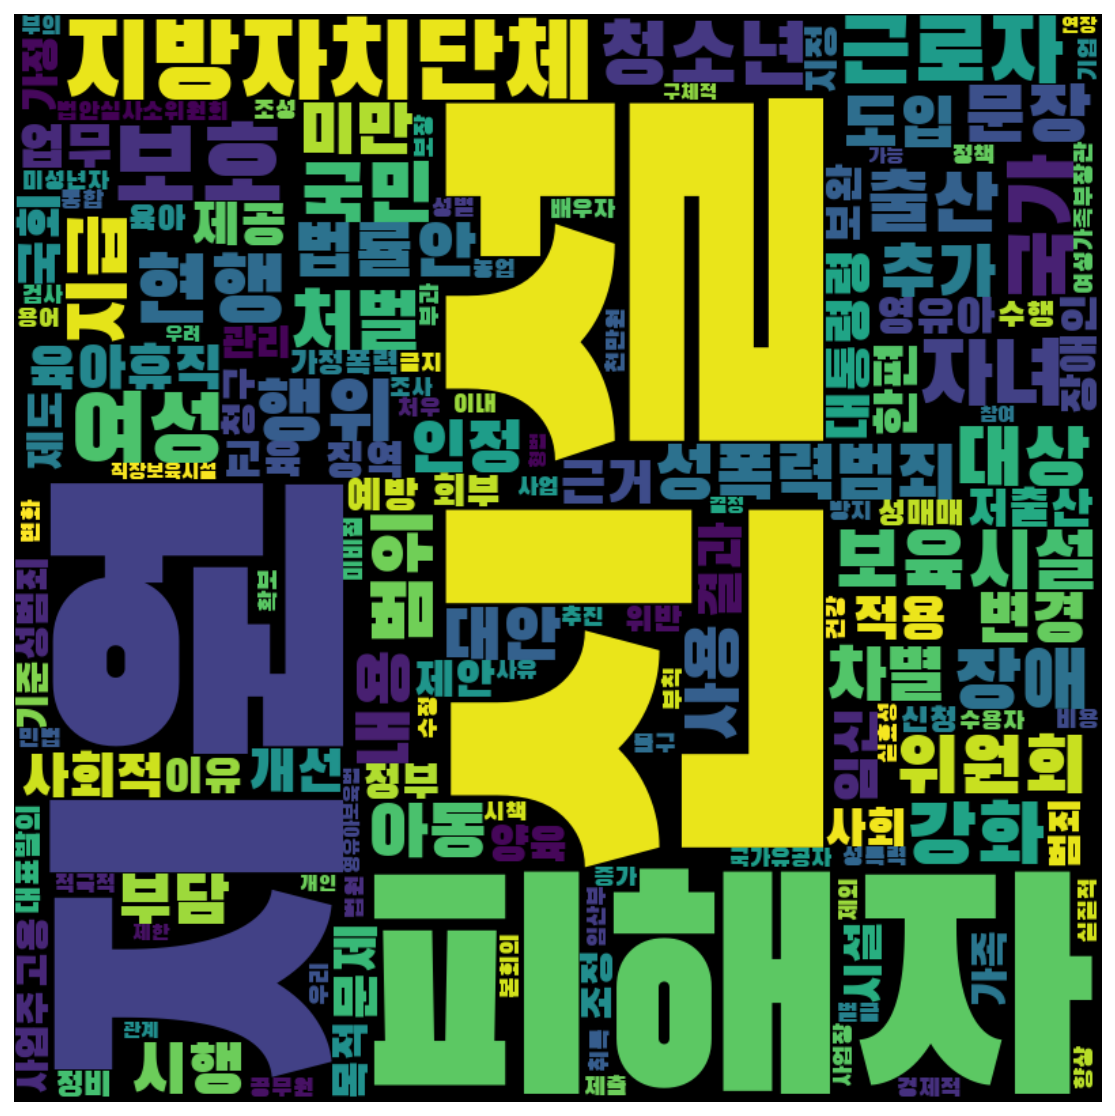

In [27]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)